# Preprocessing and clustering 3k PBMCs (legacy workflow)

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
import pandas as pd
import scanpy as sc
import kaggle
import matplotlib.pyplot as plt

In [8]:
import matplotlib
print(matplotlib.__version__)

3.9.0


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [3]:
dataset = "alexandervc/citeseq-scrnaseq-proteins-human-pbmcs-2019"
kaggle.api.dataset_download_files(dataset, path="./data", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/alexandervc/citeseq-scrnaseq-proteins-human-pbmcs-2019


In [4]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [5]:
adata = sc.read_csv(
    'data/GSM3681518_MNC_RNA_counts.tsv/citeseq_rna_counts.tsv',
    delimiter="\t",
    first_column_names=True
)

In [6]:
adata = adata.T
adata

AnnData object with n_obs × n_vars = 33454 × 17009

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
adata

AnnData object with n_obs × n_vars = 33454 × 17009

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:04)


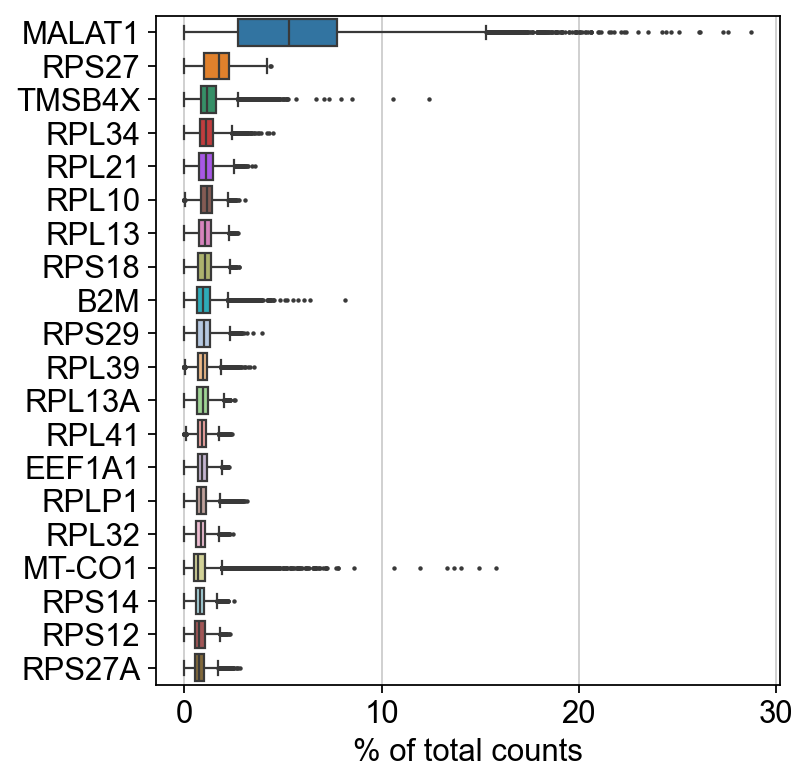

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [10]:
print("Cells before:", adata.shape[0])
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("Cells after:", adata.shape[0])

Cells before: 33454
filtered out 6 cells that have less than 200 genes expressed
filtered out 1 genes that are detected in less than 3 cells
Cells after: 33448


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [11]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

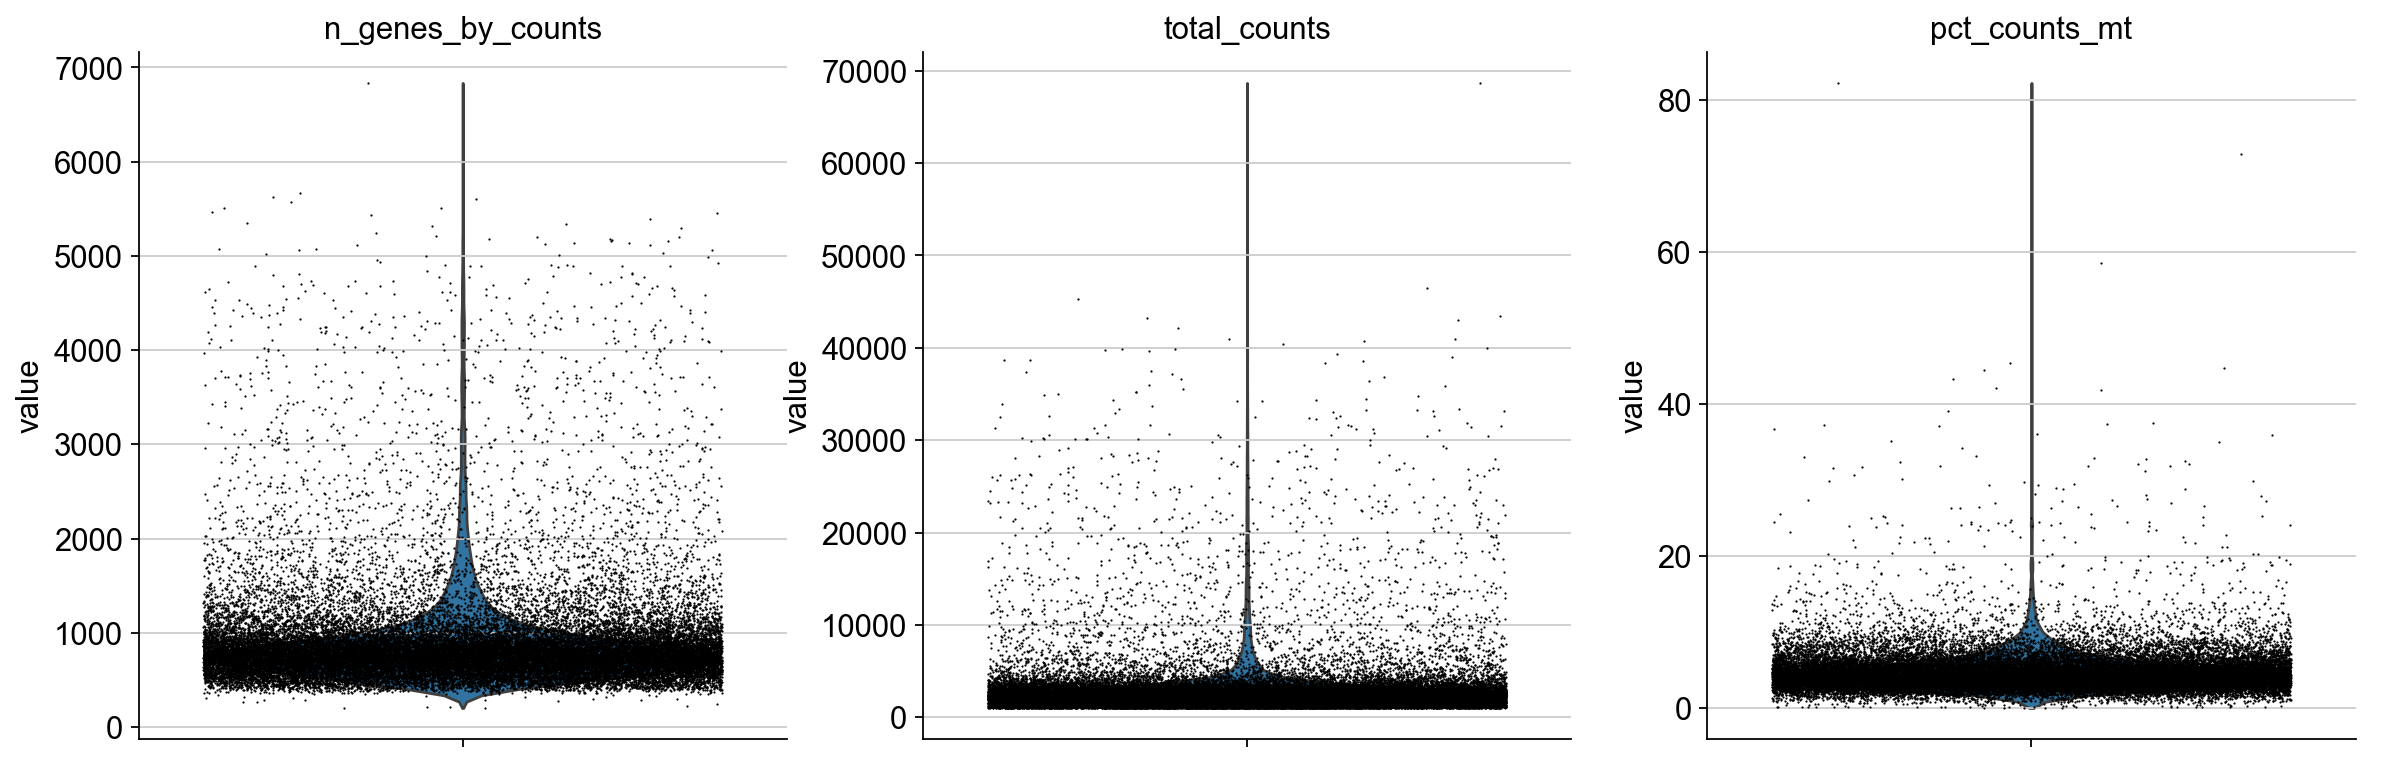

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

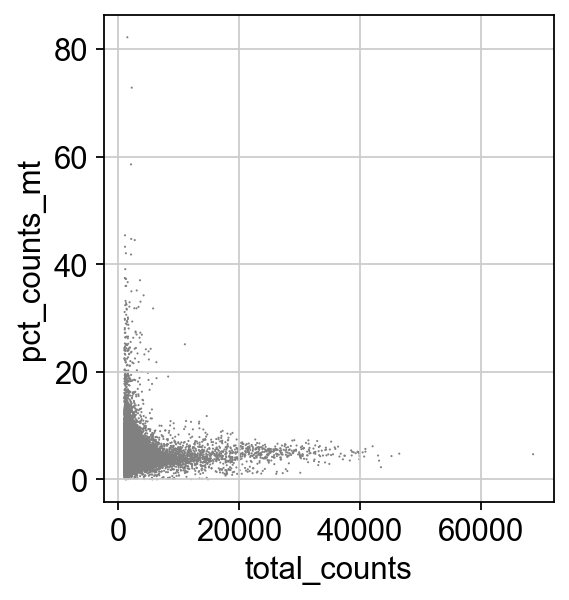

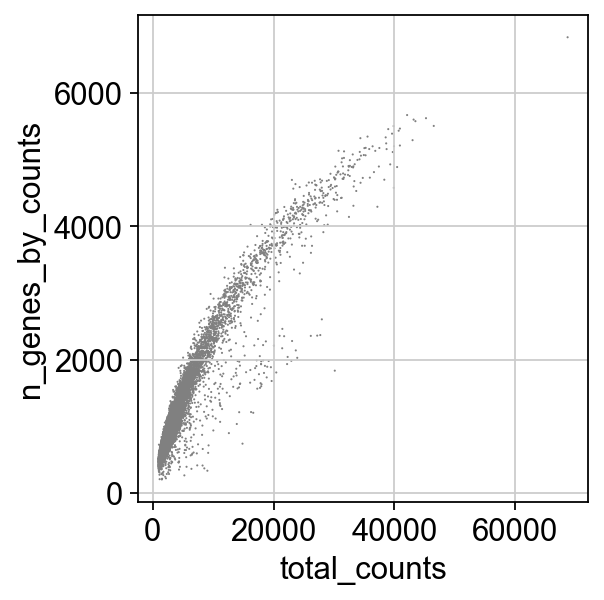

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Actually do the filtering by slicing the `AnnData` object.

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [16]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


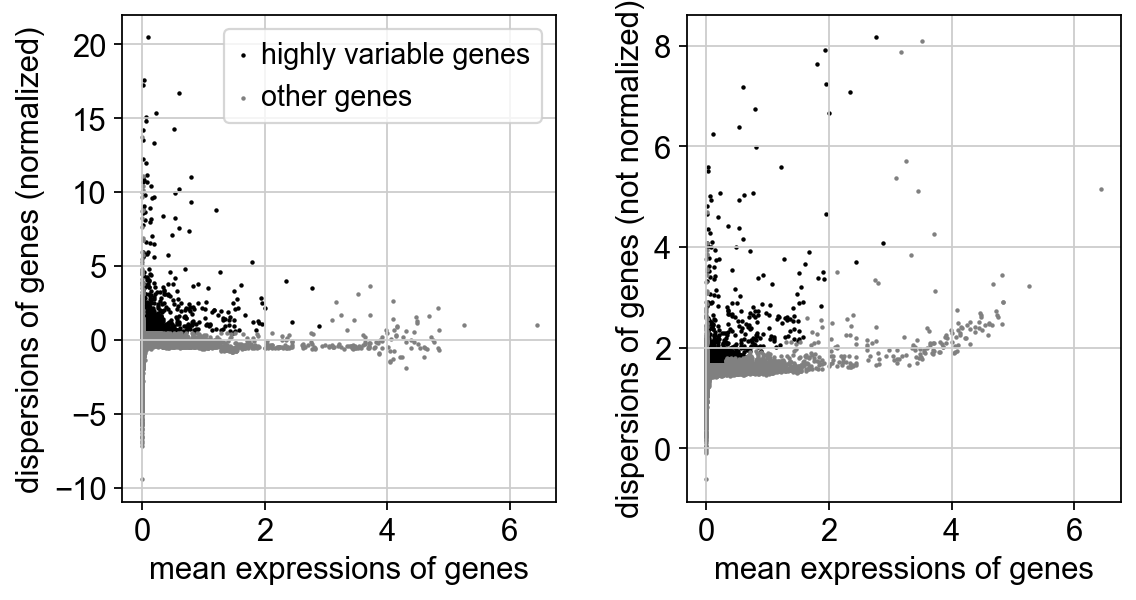

In [18]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

:::{note}
You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.
:::

In [19]:
adata.raw = adata.copy()

:::{note}
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.
:::

Actually do the filtering

In [20]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [21]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']


/Users/venikkus/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:03)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [22]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [23]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:04)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

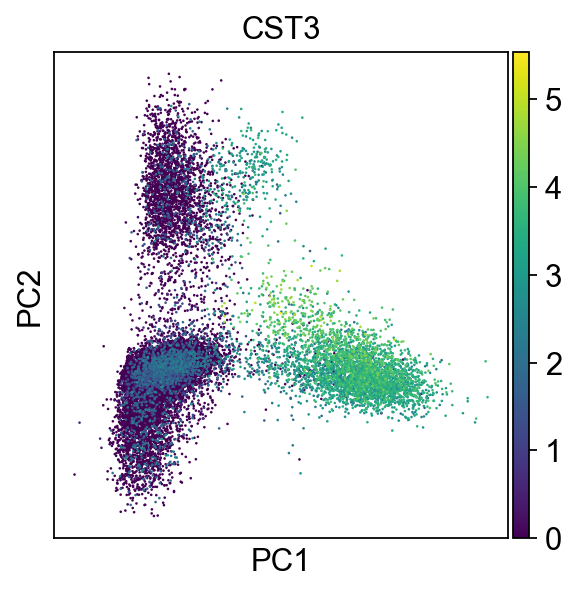

In [24]:
sc.pl.pca(adata, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

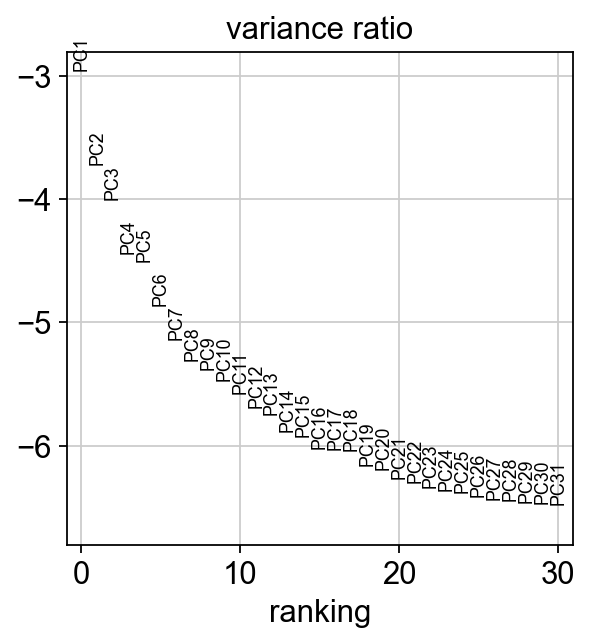

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 21839 × 1063
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


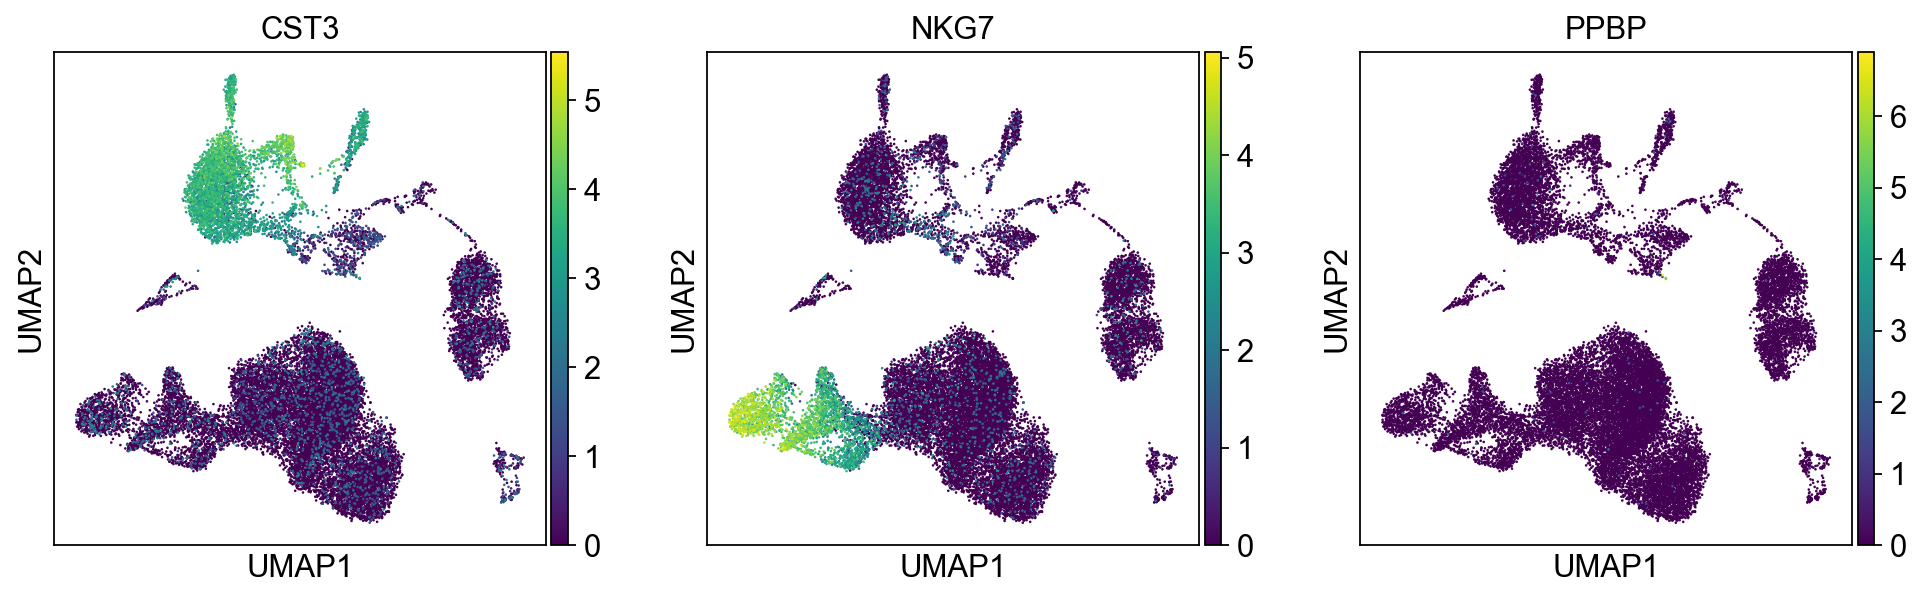

In [30]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

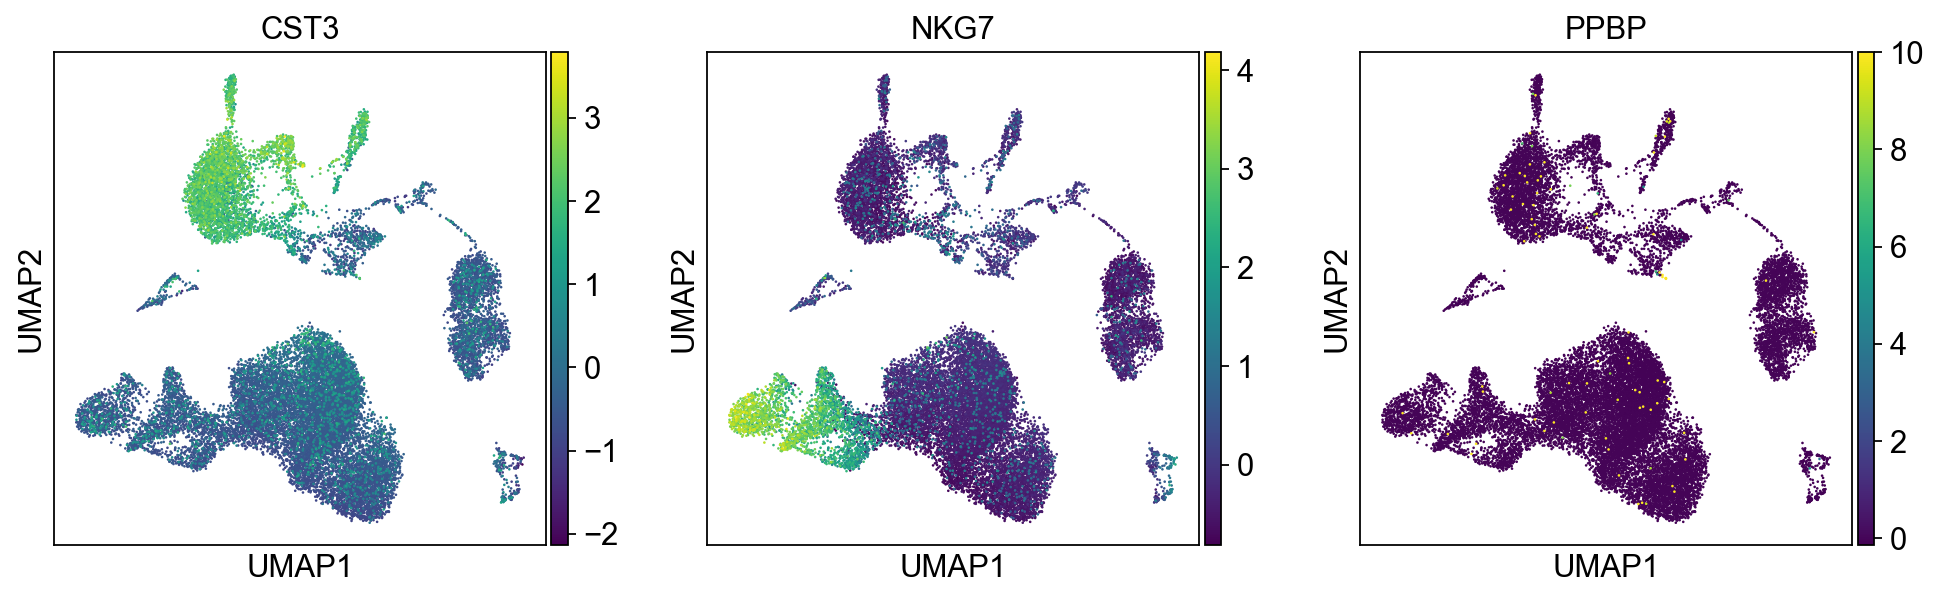

In [31]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [32]:
sc.tl.leiden(
    adata,
    resolution=0.2,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

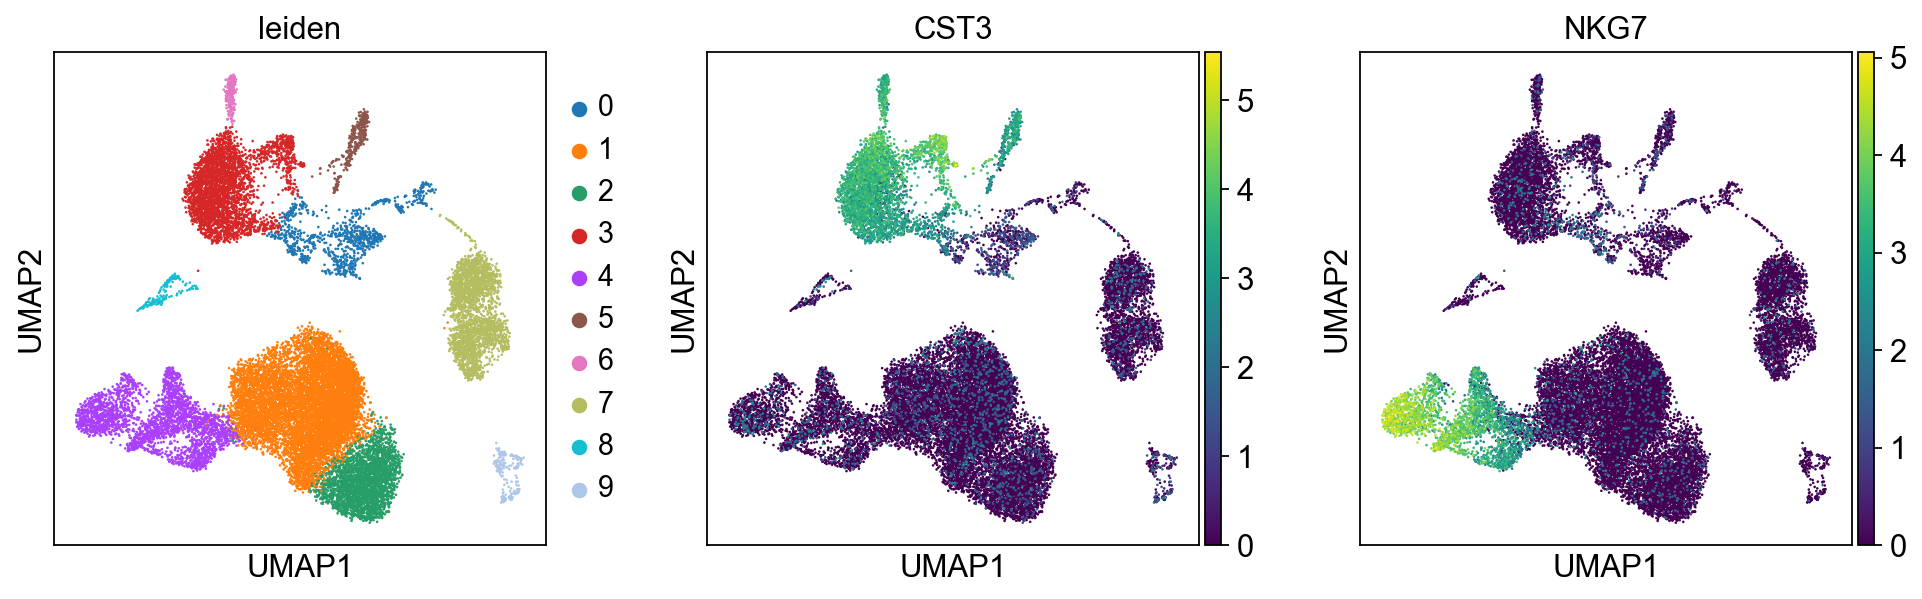

In [33]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

Save the result.

In [34]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:37)


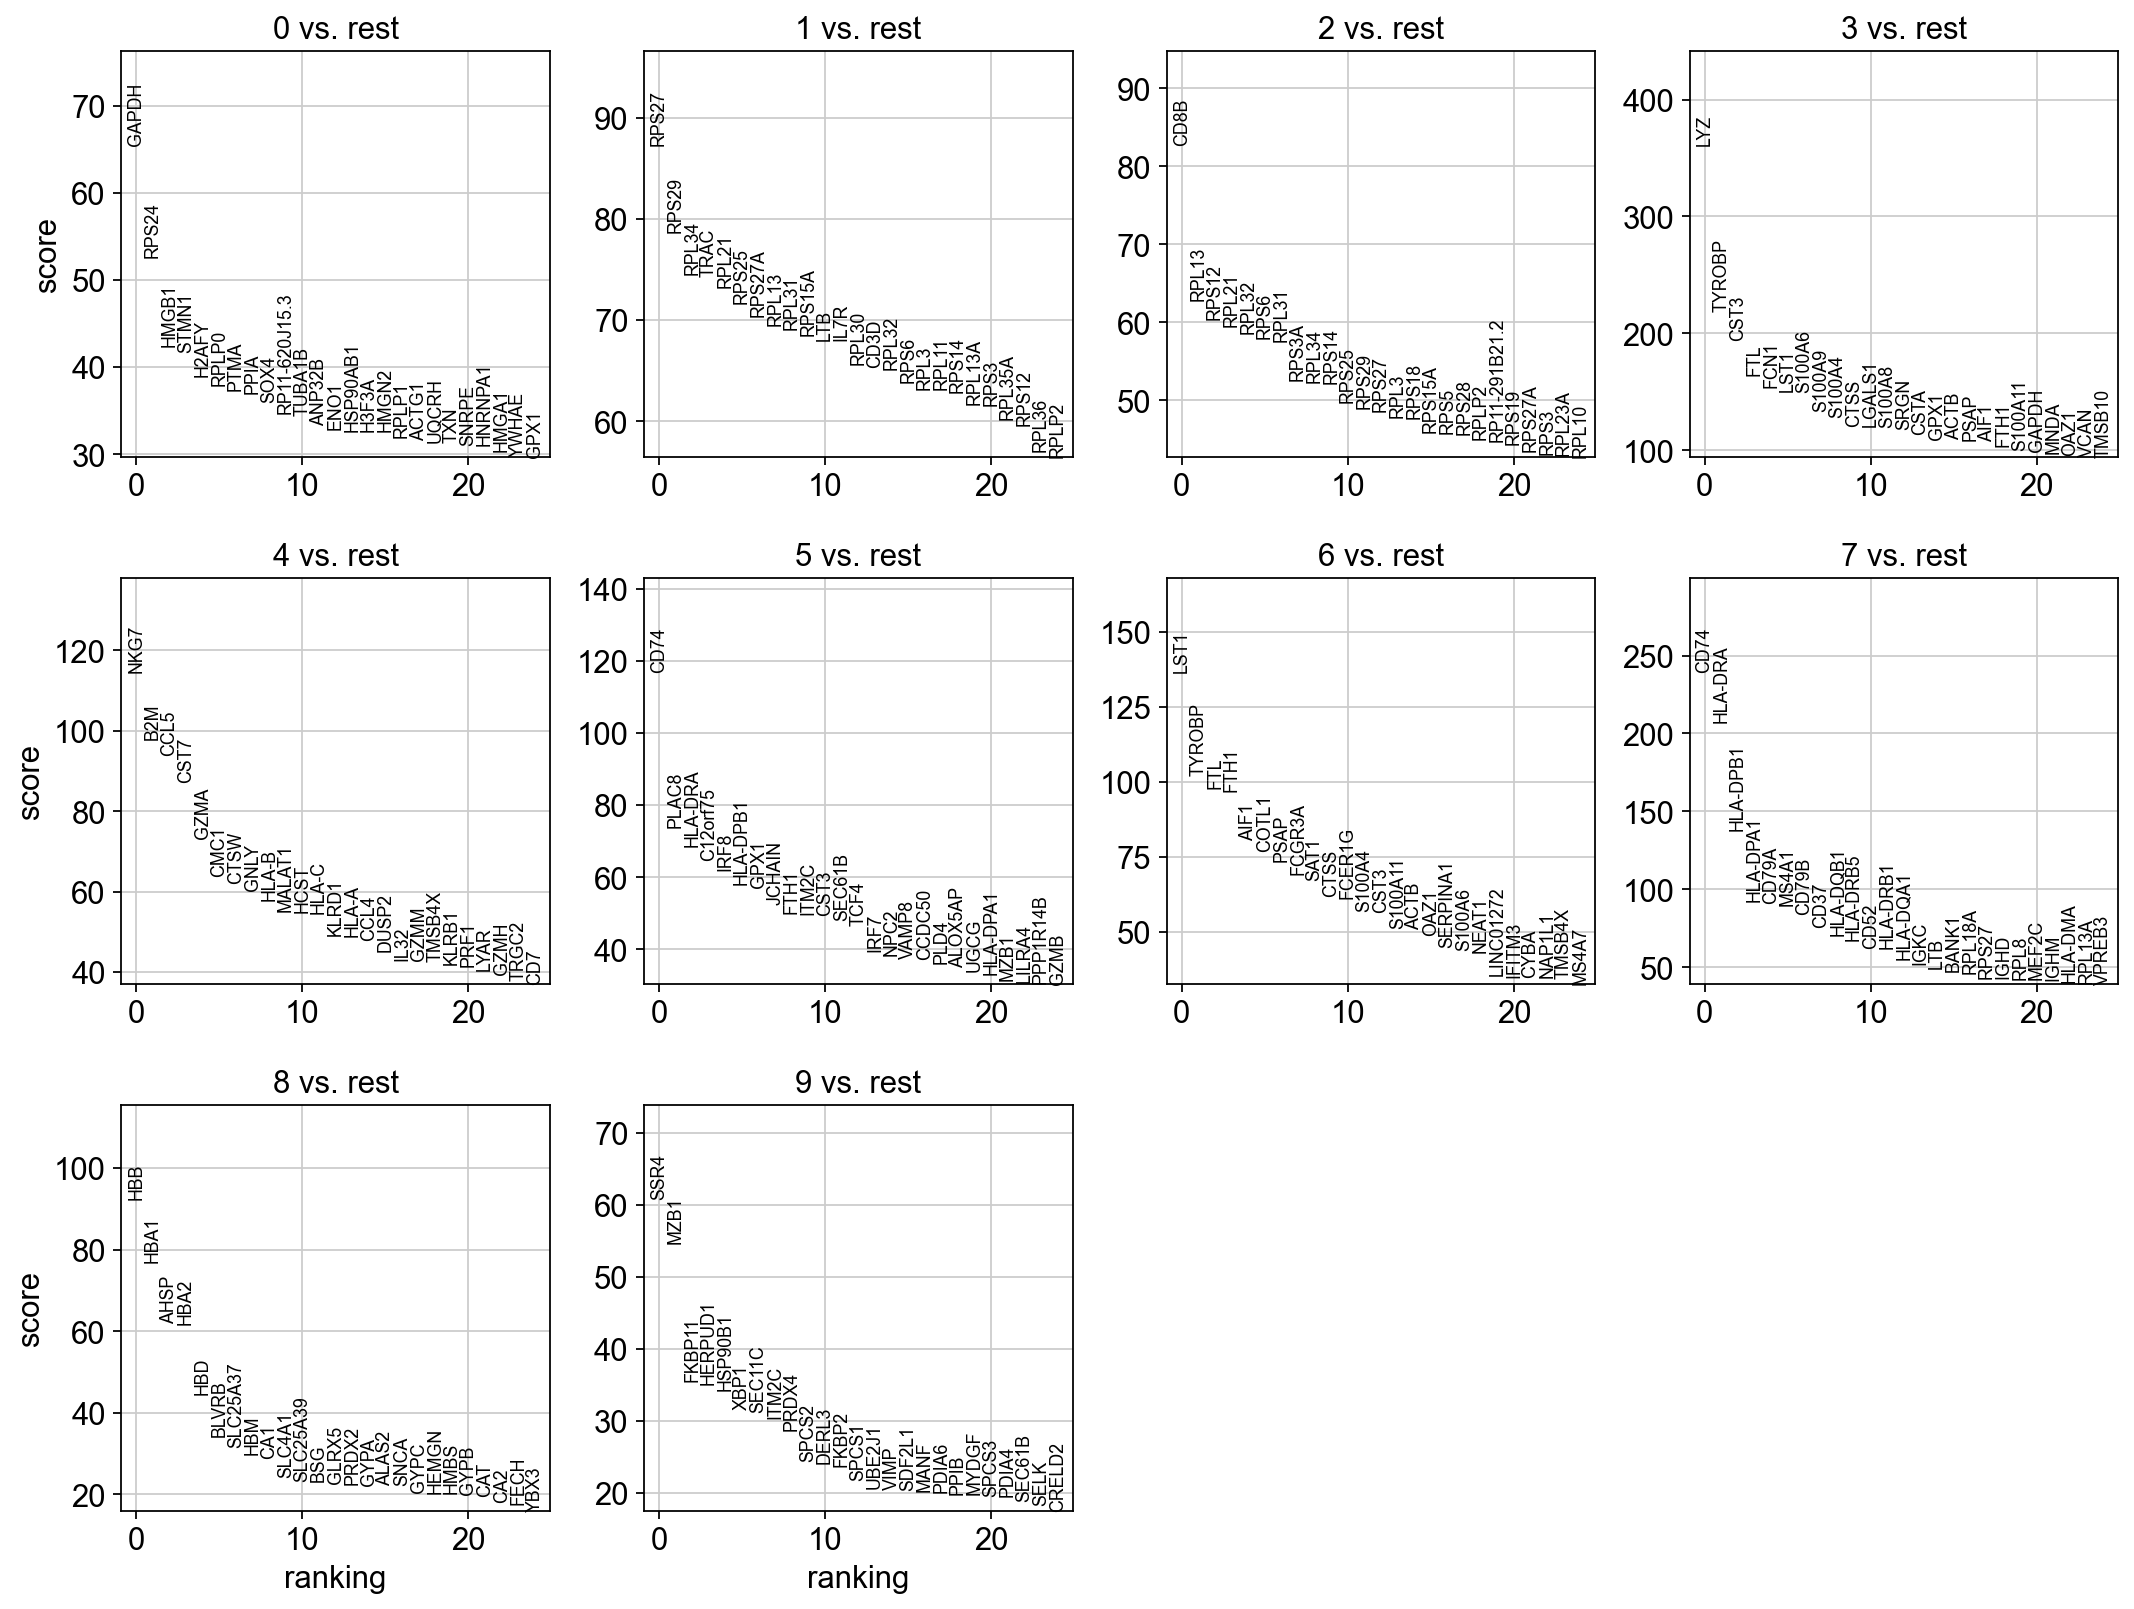

In [35]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:44)


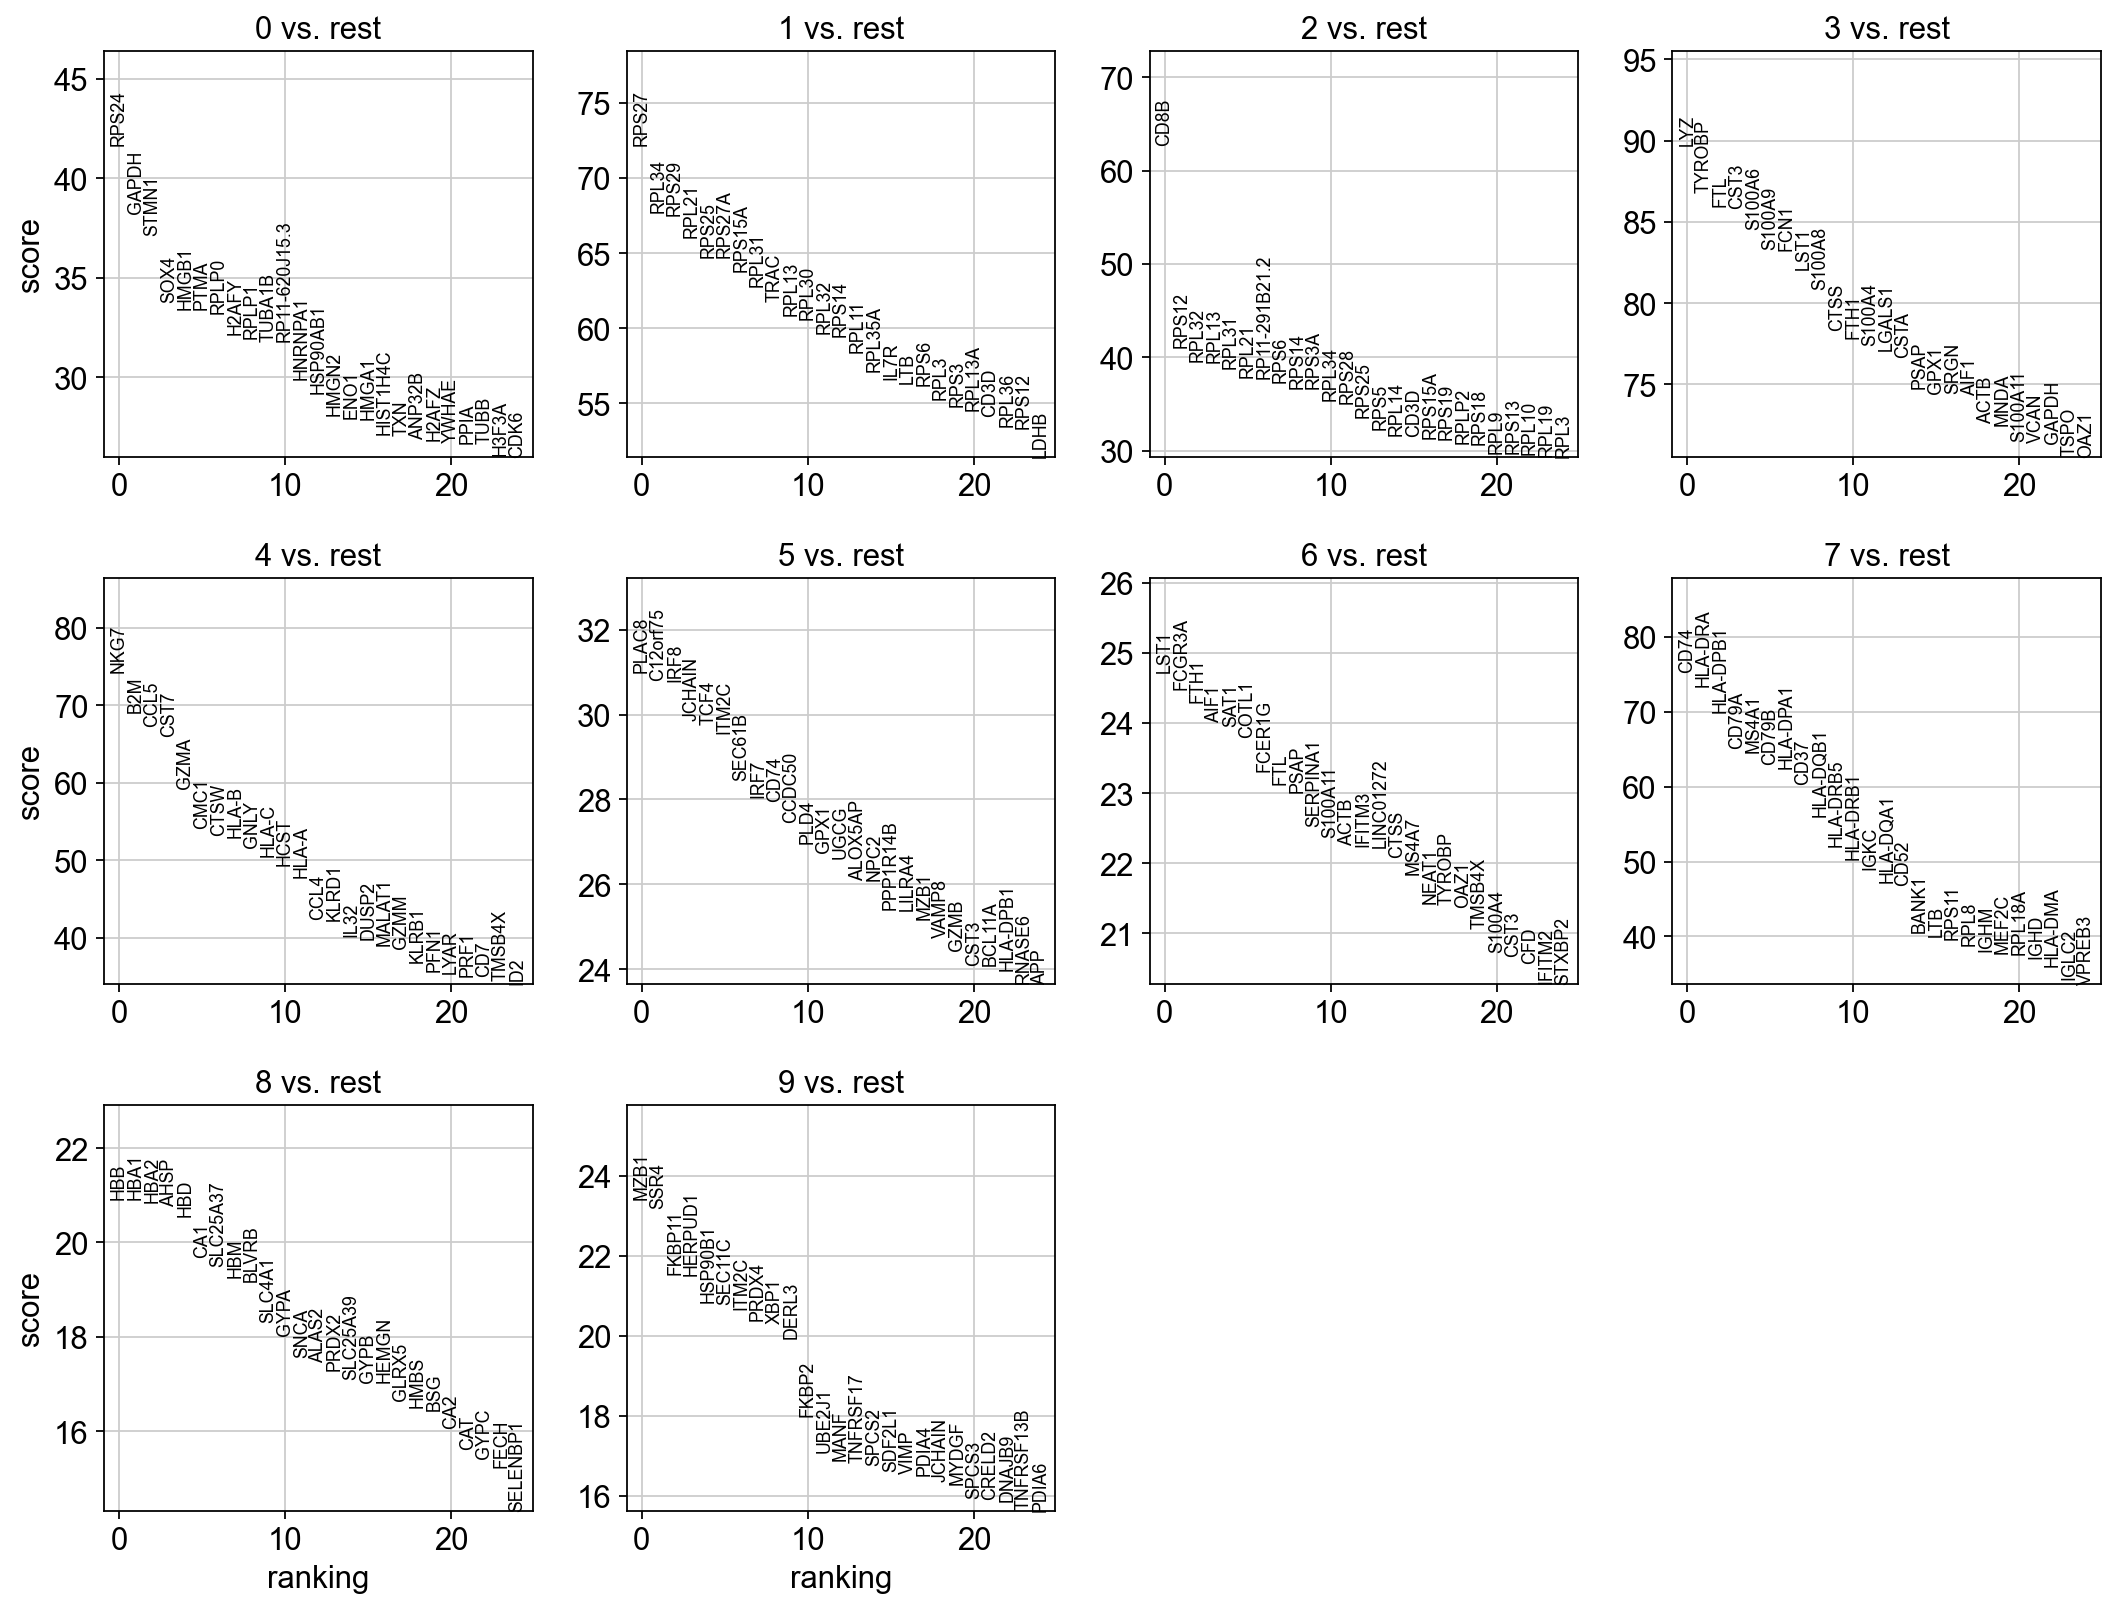

In [37]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [38]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:07:54)


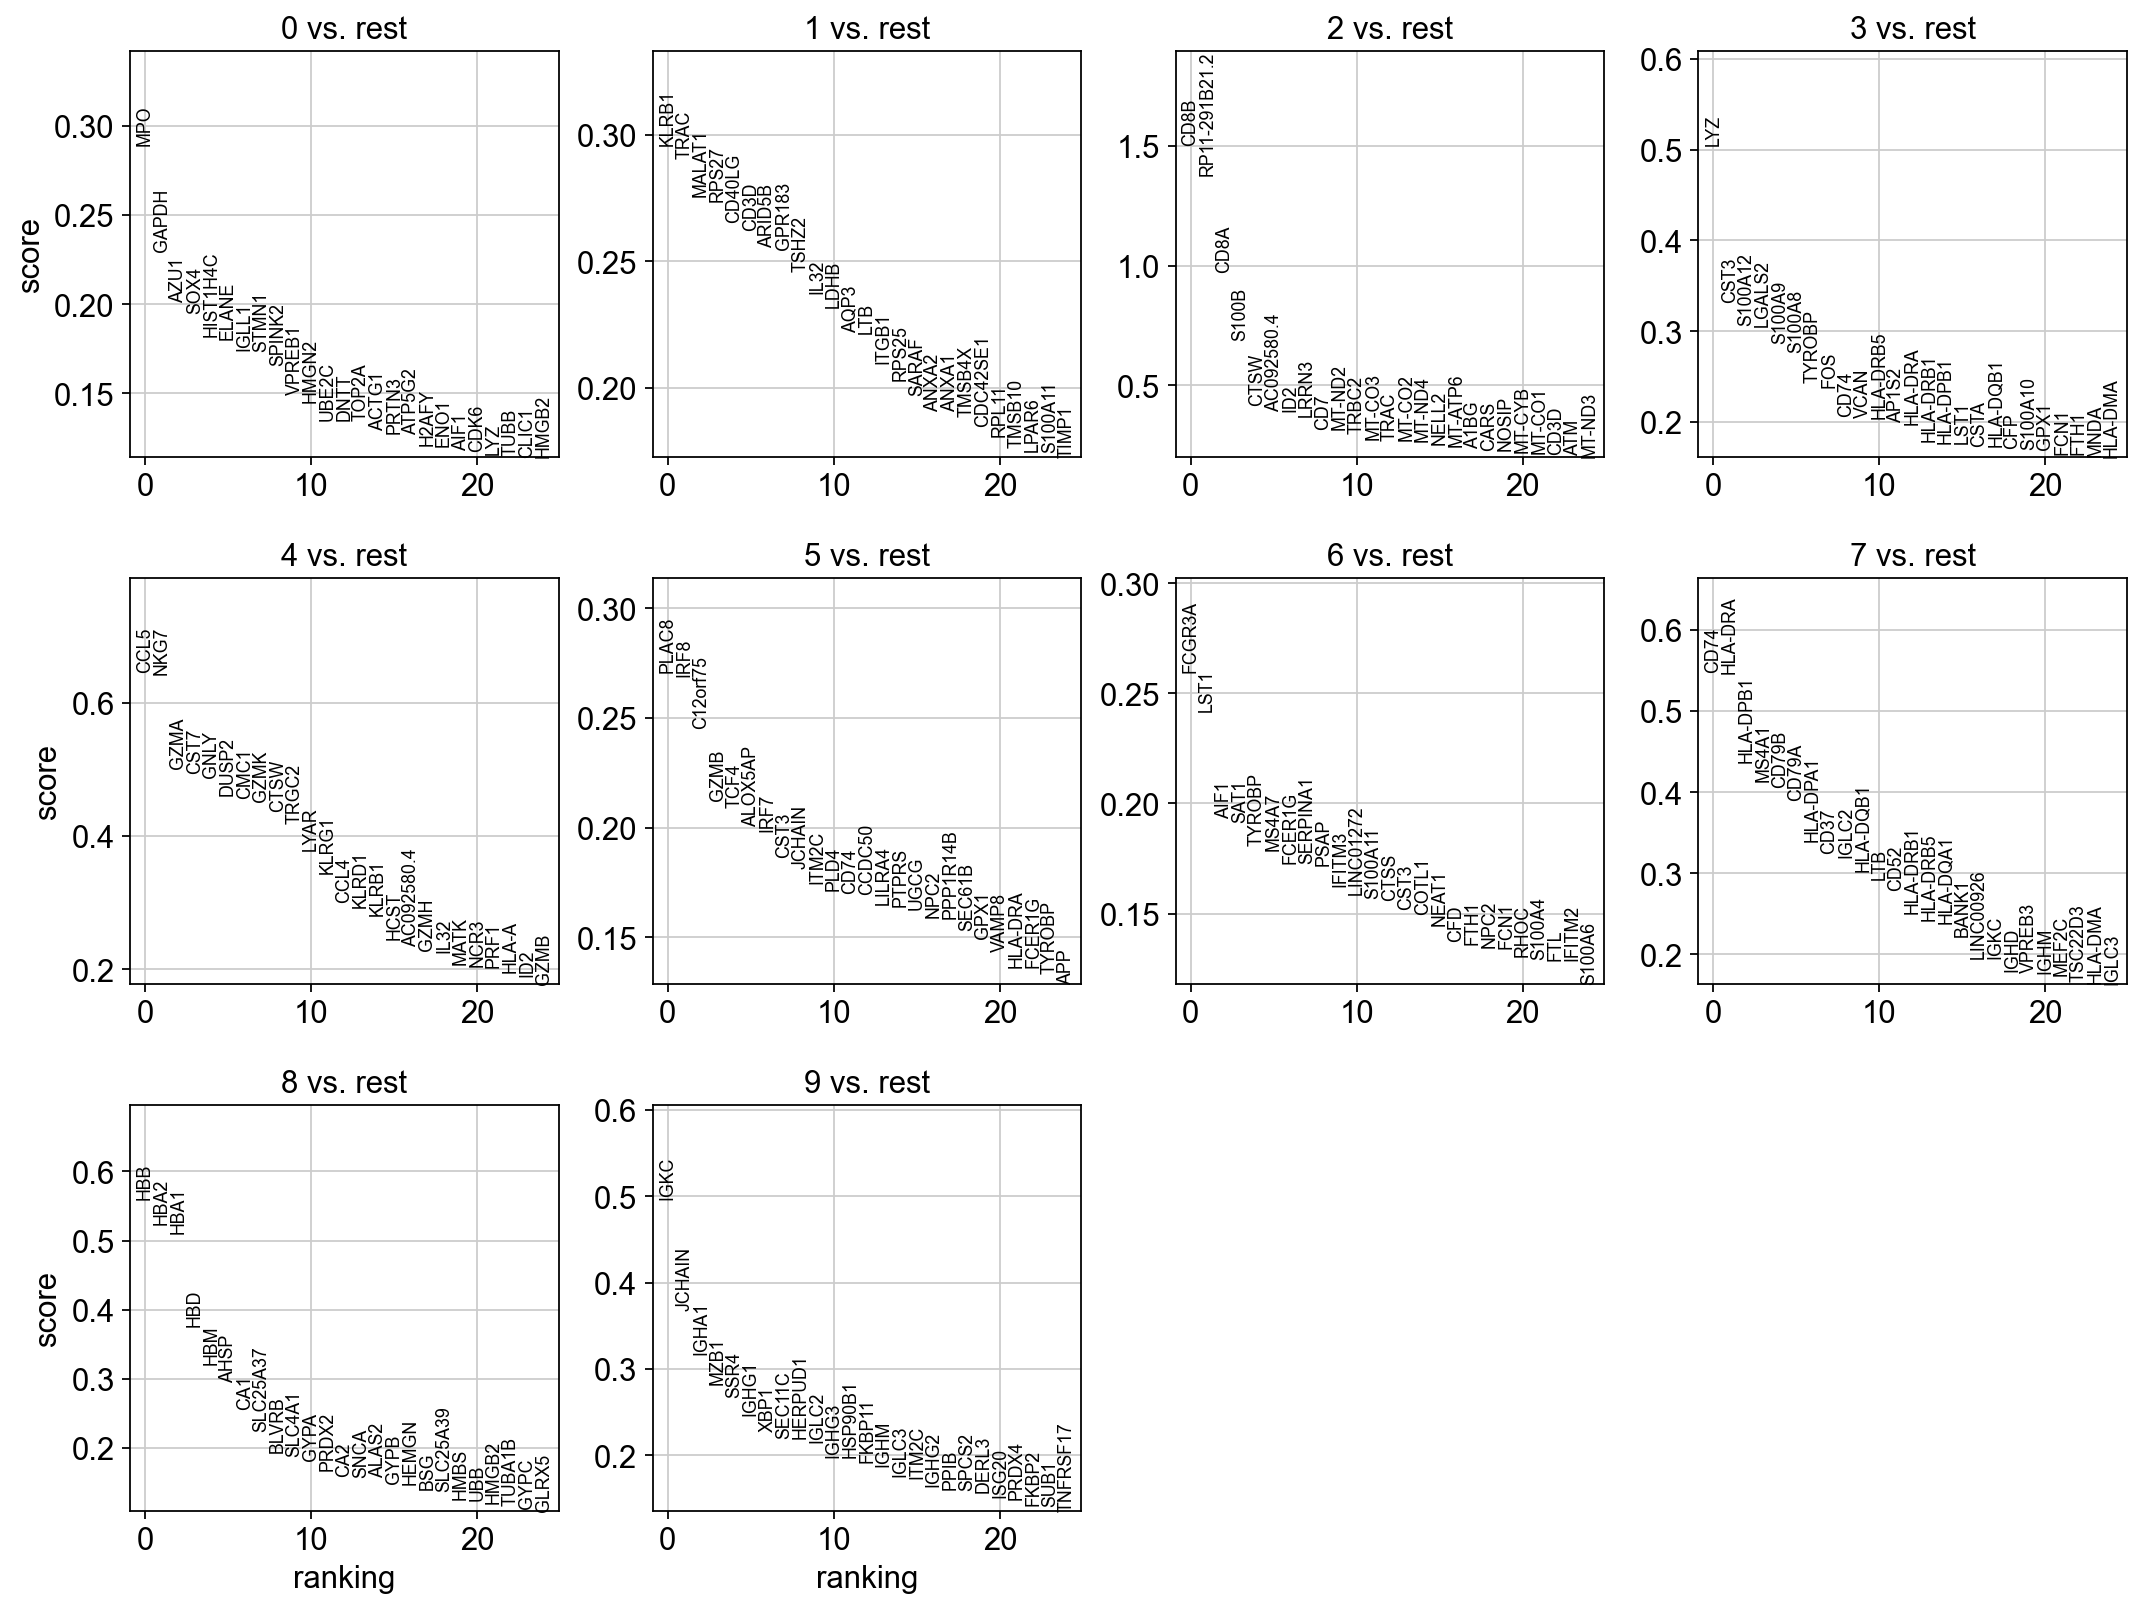

In [39]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [40]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [41]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [42]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0      1      2       3     4         5       6         7     8  \
0  RPS24  RPS27   CD8B     LYZ  NKG7     PLAC8    LST1      CD74   HBB   
1  GAPDH  RPL34  RPS12  TYROBP   B2M  C12orf75  FCGR3A   HLA-DRA  HBA1   
2  STMN1  RPS29  RPL32     FTL  CCL5      IRF8    FTH1  HLA-DPB1  HBA2   
3   SOX4  RPL21  RPL13    CST3  CST7    JCHAIN    AIF1     CD79A  AHSP   
4  HMGB1  RPS25  RPL31  S100A6  GZMA      TCF4    SAT1     MS4A1   HBD   

         9  
0     MZB1  
1     SSR4  
2   FKBP11  
3  HERPUD1  
4  HSP90B1

Get a table with the scores and groups.

In [43]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p    1_n  1_p    2_n  2_p     3_n  3_p   4_n  4_p  \
0  RPS24   0.000000e+00  RPS27  0.0   CD8B  0.0     LYZ  0.0  NKG7  0.0   
1  GAPDH   0.000000e+00  RPL34  0.0  RPS12  0.0  TYROBP  0.0   B2M  0.0   
2  STMN1  6.311645e-302  RPS29  0.0  RPL32  0.0     FTL  0.0  CCL5  0.0   
3   SOX4  5.626871e-250  RPL21  0.0  RPL13  0.0    CST3  0.0  CST7  0.0   
4  HMGB1  3.704654e-245  RPS25  0.0  RPL31  0.0  S100A6  0.0  GZMA  0.0   

        5_n            5_p     6_n            6_p       7_n  7_p   8_n  \
0     PLAC8  4.285922e-211    LST1  5.149862e-135      CD74  0.0   HBB   
1  C12orf75  1.679933e-208  FCGR3A  2.385667e-132   HLA-DRA  0.0  HBA1   
2      IRF8  4.265873e-208    FTH1  2.165971e-130  HLA-DPB1  0.0  HBA2   
3    JCHAIN  4.920712e-196    AIF1  1.694953e-127     CD79A  0.0  AHSP   
4      TCF4  9.023827e-195    SAT1  8.542286e-127     MS4A1  0.0   HBD   

            8_p      9_n            9_p  
0  3.080480e-97     MZB1  2.369193e-121  
1  3.187458e-97     SSR4  5.027135e-119  
2  1.457238e-96   FKBP11  5.183640e-103  
3  9.032556e-96  HERPUD1  1.175024e-102  
4  5.115416e-94  HSP90B1   1.654717e-96

Compare to a single cluster: 

ranking genes


    finished (0:00:07)


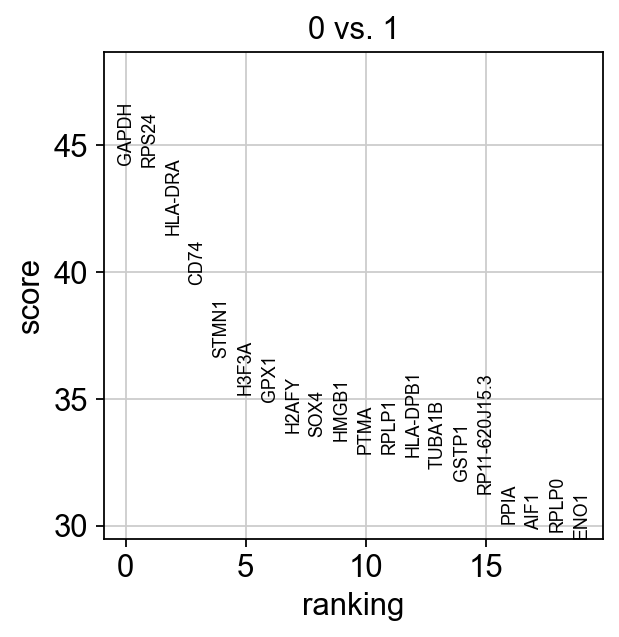

In [44]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/Users/venikkus/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


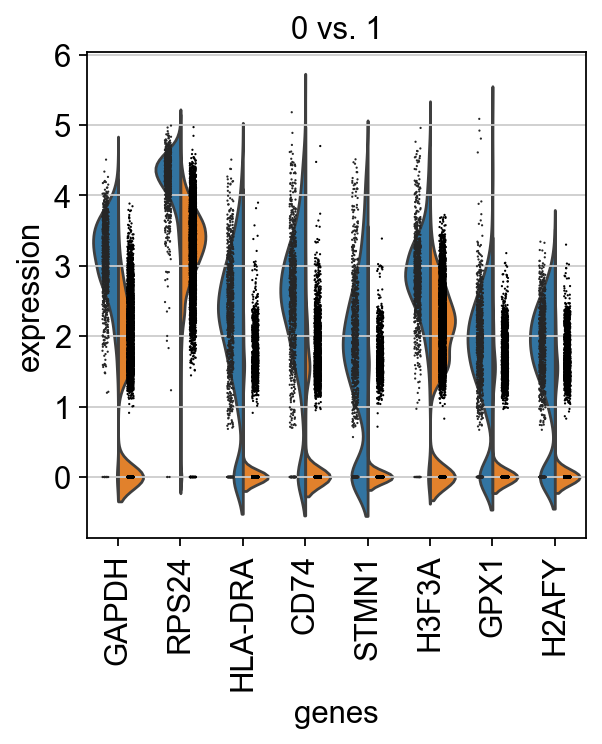

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [46]:
adata = sc.read(results_file)

/Users/venikkus/miniconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1324: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


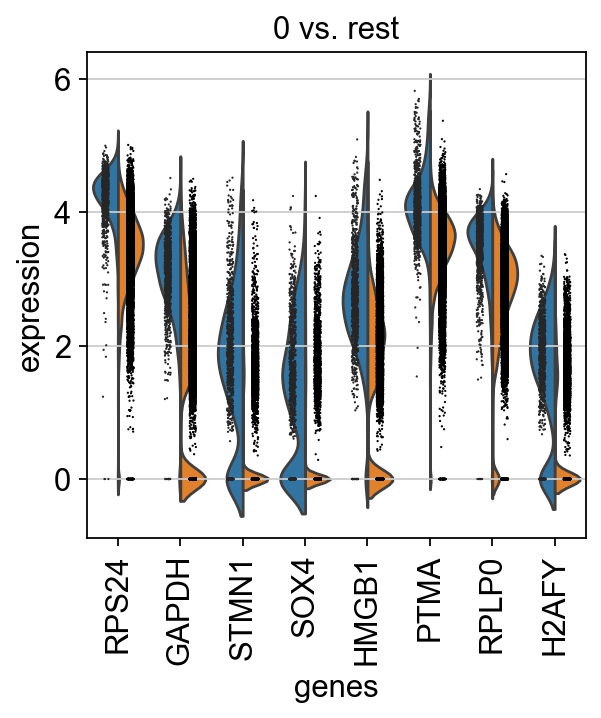

In [47]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

If you want to compare a certain gene across groups, use the following.

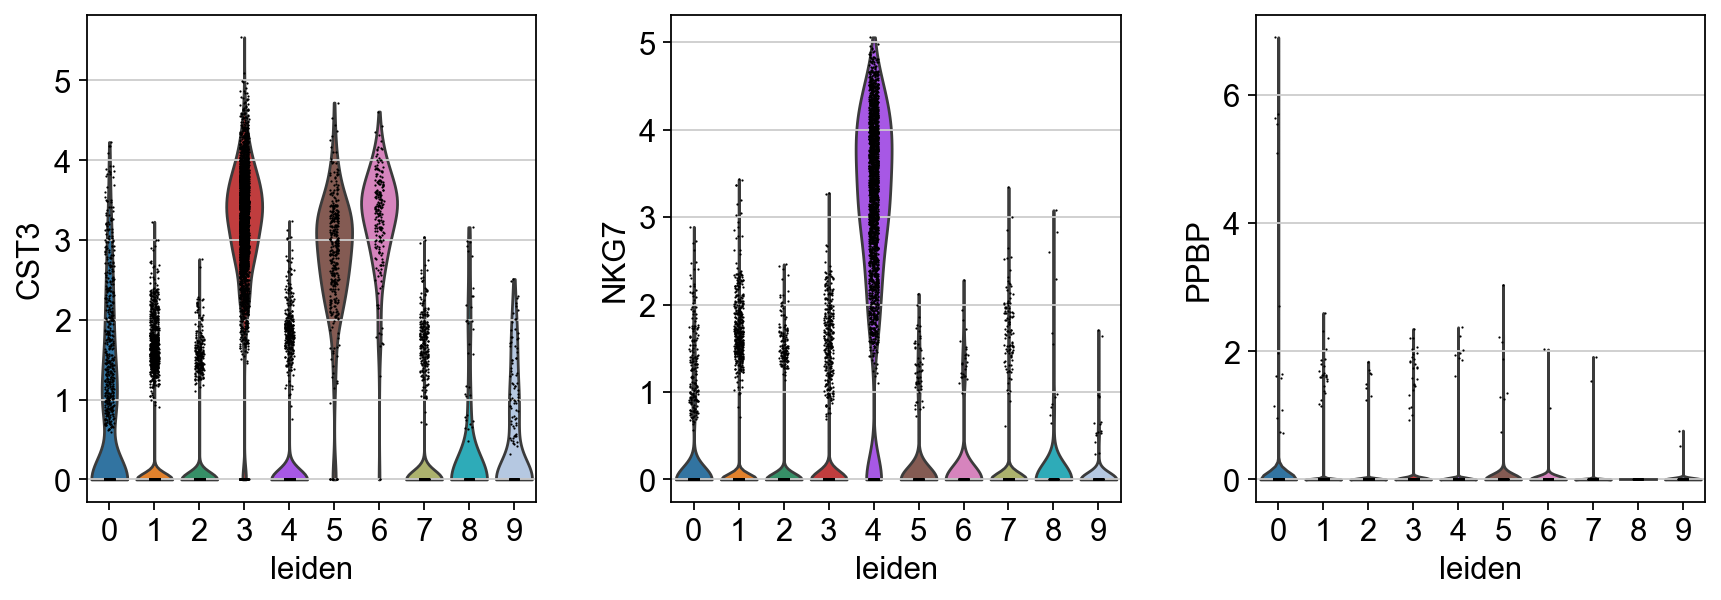

In [48]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

Actually mark the cell types.

In [49]:
adata

AnnData object with n_obs × n_vars = 21839 × 1063
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [50]:
import celltypist
from celltypist import models

In [73]:
!pip show kaggle

Name: kaggle
Version: 1.7.4.2
Summary: Access Kaggle resources anywhere
Home-page: https://github.com/Kaggle/kaggle-api
Author: 
Author-email: Kaggle <support@kaggle.com>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity,

In [51]:
# до нормализации:
adata.layers["counts"] = adata.X.copy()

# потом нормализуем:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [52]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_total(
    adata_celltypist, target_sum=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:

type(adata.X)

normalizing counts per cell
    finished (0:00:00)


numpy.ndarray

In [53]:
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /Users/venikkus/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [54]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

In [55]:
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [56]:
model_low.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [57]:
import numpy as np

adata_celltypist.X = np.nan_to_num(adata.X)

if not isinstance(adata_celltypist.X, np.ndarray):
    adata_celltypist.X = adata_celltypist.X.toarray()
    adata_celltypist.X = np.nan_to_num(adata_celltypist.X)

In [58]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

👀 Invalid expression matrix in `.X`, expect log1p normalized expression to 10000 counts per cell; will use `.raw.X` instead
🔬 Input data has 21839 cells and 17008 genes
🔗 Matching reference genes in the model
🧬 5007 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15


running Leiden clustering
    finished (0:00:10)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [59]:
predictions_high_adata = predictions_high.to_adata()

In [60]:
adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
    adata.obs.index, "conf_score"
]

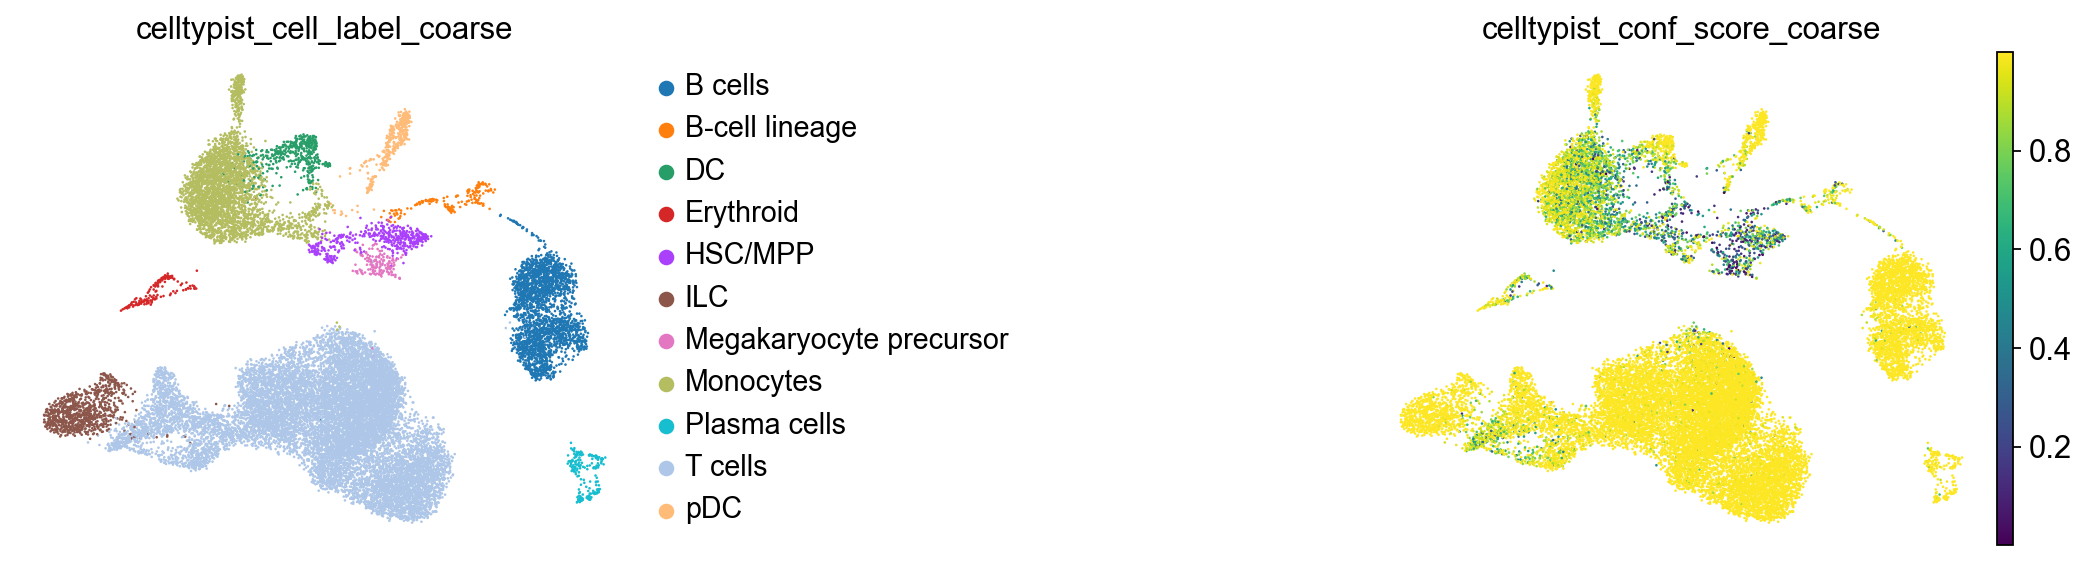

In [61]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
    frameon=False,
    sort_order=False,
    wspace=1,
    save=False,
    show=False
)
plt.savefig("umap.png", dpi=300, bbox_inches="tight")

Now that we annotated the cell types, let us visualize the marker genes.

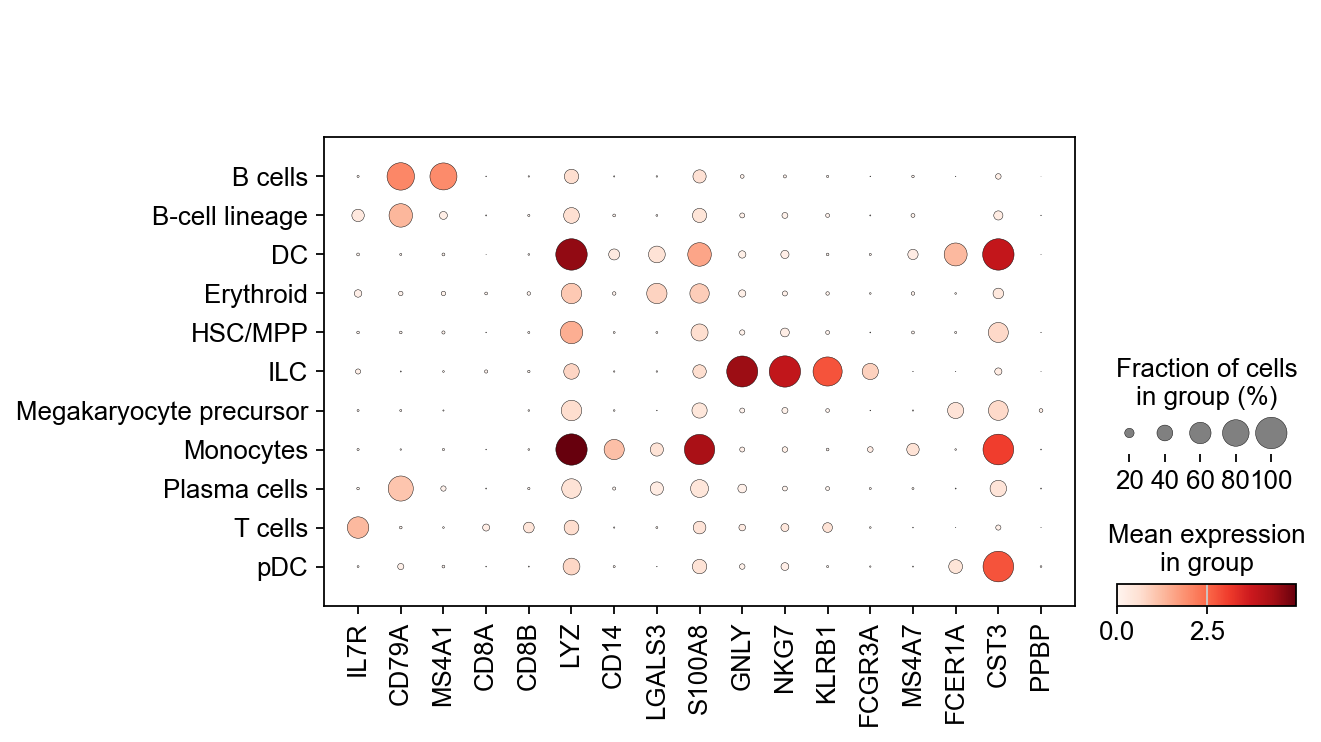

In [62]:
sc.pl.dotplot(adata, marker_genes, groupby="celltypist_cell_label_coarse", show=False);
plt.savefig("dotplot.png", dpi=300, bbox_inches="tight")

There is also a very compact violin plot.

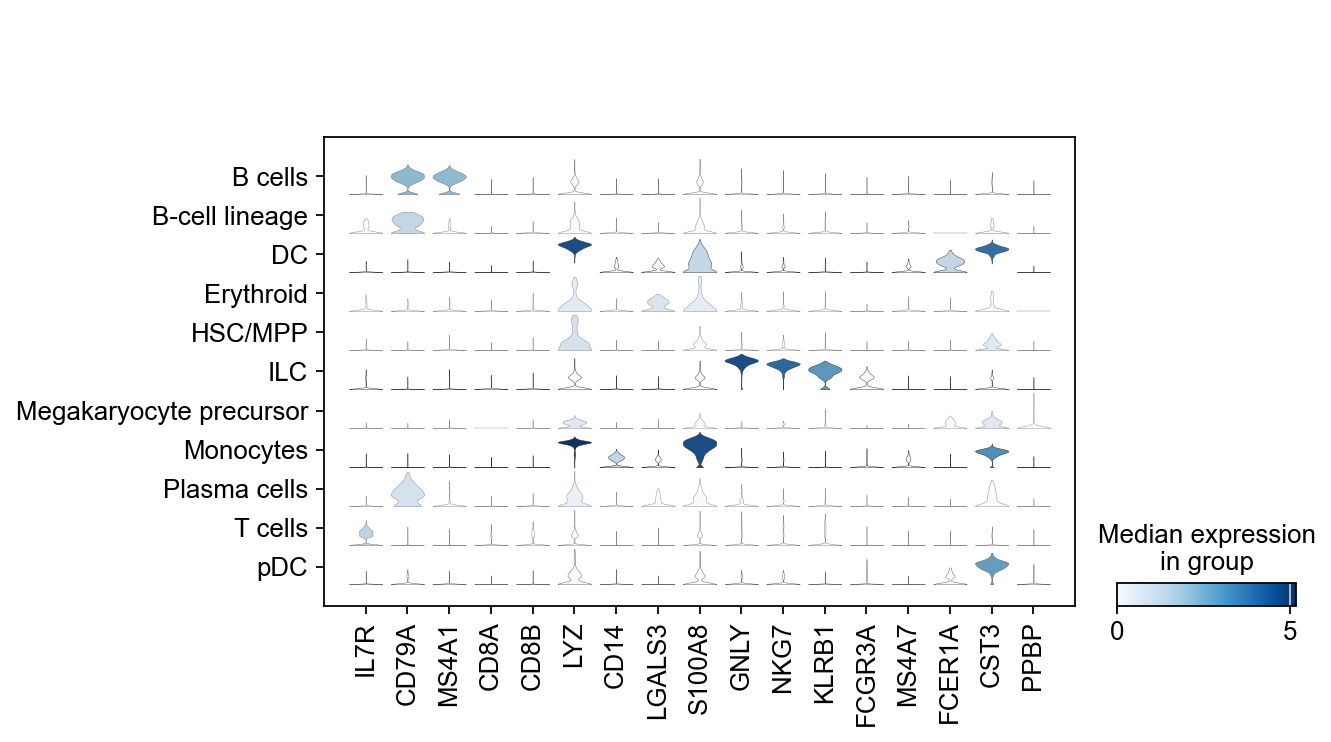

In [63]:
sc.pl.stacked_violin(adata, marker_genes, groupby="celltypist_cell_label_coarse");

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_celltypist_cell_label_coarse']`


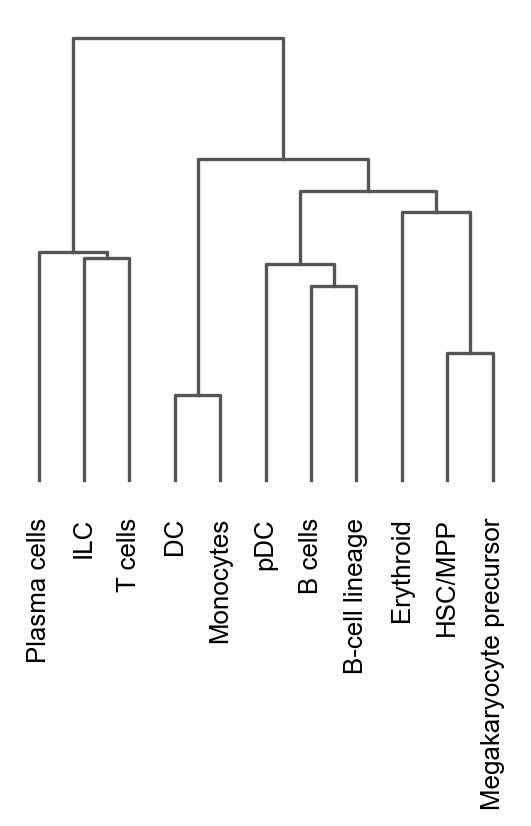

<Axes: >

In [64]:
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_coarse")

During the course of this analysis, the AnnData accumlated the following annotations.

In [65]:
adata

AnnData object with n_obs × n_vars = 21839 × 1063
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'celltypist_cell_label_coarse_colors', 'dendrogram_celltypist_cell_label_coarse'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [66]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [67]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")